# 1. Project Dependencies & Config

In [1]:
import tensorflow as tf

TF_RECORD_OUTPUT_DIR = "resources/tf_records/numeric-only/tf_12digit_pattern4" # directory of the TFRecord files to load

# Enable to limit the number of TFRecord files to use for training
LIMIT_TF_RECORD_DATASET = True # for testing, might be good to limit the number of TFRecord files to use
TF_RECORD_DATASET_LIMIT = 2 # number of TFRecord files to be used for training

# Password metadata
MAX_SEQUENCE_LENGTH = 12 # This should be the max length of the password, 12 default
VOCAB = "0123456789" # This should be the vocabulary of the password, 0123456789 default
VOCAB_SIZE = len(VOCAB)

NUM_SAMPLES = 500000  # This should be the number of samples in each dataset: 500k default
NUM_FILES = 200  # This should be the number of files in your dataset

# Training settings
EPOCHS = 10
BATCH_SIZE = 128
BUFFER_SIZE = 10000
PREFETCH_SIZE = tf.data.AUTOTUNE  # Automatically tune prefetch buffer size

# Used to create a generator/discriminiator to verify passwords are being one_hot_encoded correctly
G_OPTIMIZE_LEARNING_RATE = 0.0001
D_OPTIMIZE_LEARNING_RATE = 0.00001

# model monitor for storoing genreated passwords, not needed, can be taken out in future
FOLDER_PATH = "training_sessions"
TRAINING_SESSION = None
TRAINING_SESSION_PATH = None

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# Check if the last directory in the current path is 'notebooks'
if 'notebooks' in current_dir.split(os.sep):
    # Change the current working directory two levels up
    os.chdir('../../')
    print(f"Changed current working directory to: {os.getcwd()}\n")
else:
    print("Current directory is not inside 'notebooks', no change needed.")


Current working directory: /Users/bambrick/DevCenter/Juypter/PasswordGAN/notebooks/demo
Changed current working directory to: /Users/bambrick/DevCenter/Juypter/PasswordGAN



In [3]:
import os
import datetime

global TRAINING_SESSION
global TRAINING_SESSION_PATH

# Get the current date and time
now = datetime.datetime.now()
timestamp = now.strftime("%Y_%m_%d_%H%M%S")

TRAINING_SESSION = f"{TF_RECORD_OUTPUT_DIR.split('/')[-1]}_{timestamp}"
TRAINING_SESSION_PATH = os.path.join(FOLDER_PATH, TRAINING_SESSION)

# Create the training session folder
if not os.path.exists(TRAINING_SESSION_PATH):
    os.makedirs(TRAINING_SESSION_PATH, exist_ok=True)

# Printing the generated filename
if os.path.exists(TRAINING_SESSION_PATH):
    print(f"Created training session project folder: {TRAINING_SESSION_PATH}")
else:
    print(f"Failed to create training session project folder: {TRAINING_SESSION_PATH}")


Created training session project folder: training_sessions/tf_12digit_pattern4_2023_11_11_232310


In [4]:
import os

# Get all of the files in the folder
def get_all_files_in_folder(folder_path):
    """Return a list of all files in the specified folder."""

    # Get the current working directory
    current_directory = os.getcwd()

    # Print the current working directory
    print(f"Current Directory: {current_directory}")
    print(f"Getting all files in folder: {folder_path}")

    # List all items in the folder
    all_items = os.listdir(folder_path)
    
    return [item for item in all_items if os.path.isfile(os.path.join(folder_path, item))]

In [5]:
import tensorflow as tf

# Create a prased dataset for training the model
def load_tf_records(folder_path):
    global NUM_FILES

    # Define the feature description to parse the tf.train.Example
    feature_description = {
        'password': tf.io.FixedLenFeature([12, 10], tf.float32),
    }

    # Function to parse the examples
    def _parse_function(proto):
        parsed_features = tf.io.parse_single_example(proto, feature_description)
        return parsed_features['password']

    # Reading the TFRecord file
    tf_records = get_all_files_in_folder(folder_path)
    tf_records_path = None

    if LIMIT_TF_RECORD_DATASET:
        NUM_FILES = min(TF_RECORD_DATASET_LIMIT, len(tf_records))
        # if the number of files in the folder is less than TF_RECORD_DATASET_LIMIT, then get all of the files
        tf_records_path = [os.path.join(folder_path, item)
                           for item in tf_records[:NUM_FILES]]
    else:
        NUM_FILES = len(tf_records)
        tf_records_path = [os.path.join(folder_path, item)
                           for item in tf_records]

    # Parsing the dataset
    raw_dataset = tf.data.TFRecordDataset(tf_records_path)
    parsed_dataset = raw_dataset.map(_parse_function)

    # Batching and shuffling the dataset
    parsed_dataset = parsed_dataset.batch(BATCH_SIZE)
    parsed_dataset = parsed_dataset.shuffle(buffer_size=BUFFER_SIZE)
    parsed_dataset = parsed_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    # Repeat the dataset indefinitely - ensures there is enough data for training
    parsed_dataset = parsed_dataset.repeat()

    return parsed_dataset


In [6]:
parsed_dataset = load_tf_records(TF_RECORD_OUTPUT_DIR)

Current Directory: /Users/bambrick/DevCenter/Juypter/PasswordGAN
Getting all files in folder: resources/tf_records/numeric-only/tf_12digit_pattern4


2023-11-11 23:23:10.768169: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-11-11 23:23:10.768189: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-11-11 23:23:10.768194: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-11-11 23:23:10.768225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-11 23:23:10.768240: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
class GeneratorLSTMv2(tf.keras.Model):
    def __init__(self, noise_dim=100, **kwargs):
        super(GeneratorLSTMv2, self).__init__(**kwargs)
        
        # Initial dense layer
        self.noise_dim = noise_dim
        self.dense_1 = tf.keras.layers.Dense(256, activation='relu', input_dim=noise_dim,)
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.dropout_1 = tf.keras.layers.Dropout(0.5)
        
        # LSTM layers for sequence data
        self.reshape_1 = tf.keras.layers.Reshape((1, 256))  # Reshape input for LSTM
        self.lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)
        self.lstm_2 = tf.keras.layers.LSTM(128)
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
        
        # Output layers
        self.dense_out = tf.keras.layers.Dense(12 * 10, activation='softmax')  # Adjusted to 12 characters, 10 classes each (digits 0-9)
        self.reshape_out = tf.keras.layers.Reshape((12, 10))  # Reshape for output
    
    def call(self, inputs, training=False):
        x = self.dense_1(inputs)
        x = self.batch_norm_1(x, training=training)
        x = self.dropout_1(x, training=training)
        
        x = self.reshape_1(x)
        x = self.lstm_1(x)
        x = self.lstm_2(x)
        x = self.batch_norm_2(x, training=training)
        x = self.dropout_2(x, training=training)
        
        x = self.dense_out(x)
        x = self.reshape_out(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            'noise_dim': self.noise_dim
            #self.dense_1.input_shape[-1]  # Accessing the last element of the input_shape tuple
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Now, you can build your model by instantiating the class
generator = GeneratorLSTMv2(noise_dim=100)
dummy_input = tf.random.normal(shape=(1, 100))  # Assuming noise_dim is 100
generator(dummy_input)  # Build the model by calling it


<tf.Tensor: shape=(1, 12, 10), dtype=float32, numpy=
array([[[0.00854475, 0.00823159, 0.00839481, 0.00825113, 0.00838921,
         0.00841496, 0.0084386 , 0.00820875, 0.00825488, 0.00847967],
        [0.00845454, 0.00865431, 0.00855264, 0.00842359, 0.00816466,
         0.00849619, 0.00825898, 0.00815937, 0.00845559, 0.00837268],
        [0.00832873, 0.00840282, 0.00812982, 0.00815672, 0.00823552,
         0.00836173, 0.00839075, 0.00827507, 0.00847908, 0.00818234],
        [0.00826961, 0.00864331, 0.00835104, 0.00801674, 0.00813148,
         0.00839332, 0.00829621, 0.00832222, 0.00842986, 0.00825962],
        [0.00837312, 0.00824684, 0.00829893, 0.00805303, 0.00851742,
         0.00827779, 0.00829227, 0.00871002, 0.00847972, 0.00825868],
        [0.00835559, 0.008146  , 0.0085278 , 0.00831414, 0.0080941 ,
         0.00848406, 0.00841119, 0.00852509, 0.00821277, 0.00825537],
        [0.00818217, 0.00849602, 0.00831305, 0.00829565, 0.00810169,
         0.00851994, 0.00804506, 0.00822424,

In [8]:
class DiscriminatorLSTMv2(tf.keras.Model):

    def __init__(self, input_shape=(12, 10), **kwargs):
        super(DiscriminatorLSTMv2, self).__init__(**kwargs)
        self._input_shape = input_shape  # Save input_shape as an attribute    
        self.flatten = tf.keras.layers.Flatten(input_shape=input_shape)
        
        # Layer 1
        self.dense_1 = tf.keras.layers.Dense(256)
        self.leaky_relu_1 = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.dropout_1 = tf.keras.layers.Dropout(0.5)
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()
        
        # Layer 2
        self.dense_2 = tf.keras.layers.Dense(128)
        self.leaky_relu_2 = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()
        
        # Output layer
        self.dense_out = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, inputs, training=False):
        x = self.flatten(inputs)
        
        x = self.dense_1(x)
        x = self.leaky_relu_1(x)
        x = self.dropout_1(x, training=training)
        x = self.batch_norm_1(x, training=training)
        
        x = self.dense_2(x)
        x = self.leaky_relu_2(x)
        x = self.dropout_2(x, training=training)
        x = self.batch_norm_2(x, training=training)
        
        x = self.dense_out(x)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'input_shape': self._input_shape  # Directly use the input_shape passed during initialization
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Now, you can build your model by instantiating the class
discriminator = DiscriminatorLSTMv2()
dummy_input = tf.random.normal(shape=(1, 12, 10))  # Matching the expected input shape
discriminator(dummy_input)  # Build the model by calling it

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5268726]], dtype=float32)>

In [9]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy

def configure_losses_optimizers():
    gen_opt = Adam(learning_rate=G_OPTIMIZE_LEARNING_RATE)
    gen_loss = BinaryCrossentropy()
    
    dis_opt = Adam(learning_rate=D_OPTIMIZE_LEARNING_RATE)
    dis_loss = BinaryCrossentropy()

    return gen_opt, gen_loss, dis_opt, dis_loss

gen_opt, gen_loss, dis_opt, dis_loss = configure_losses_optimizers()

In [10]:
class RanPassGAN(tf.keras.Model): #(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 

    def get_config(self):
        return {
            "generator_config": self.generator.get_config(),
            "discriminator_config": self.discriminator.get_config()
        }

    @classmethod
    def from_config(cls, config):
        # You might need to modify this depending on how your generator and discriminator are initialized
        generator = GeneratorLSTMv2.from_config(config['generator_config'])
        discriminator = DiscriminatorLSTMv2.from_config(config['discriminator_config'])
        
        return cls(generator=generator, discriminator=discriminator)

    def call(self, inputs, training=False):
        generated_passwords = self.generator(inputs, training=training)
        return generated_passwords
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 
        
    def train_step(self, batch):
        # Get the data 
        real_passwords = batch
        batch_size = tf.shape(real_passwords)[0]  # Dynamically get the batch size

        # Generate noise for the generator
        noise = tf.random.normal([batch_size, 100])

        # Generate fake passwords using the generator
        fake_passwords = self.generator(noise, training=True)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake passwords to the discriminator model
            yhat_real = self.discriminator(real_passwords, training=True) 
            yhat_fake = self.discriminator(fake_passwords, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes passwords
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new passwords
            gen_passwords = self.generator(tf.random.normal((128, 100)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_passwords, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [11]:
import os

import tensorflow as tf
import numpy as np

class ModelMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_passwords=10, latent_dim=100):
        self.num_passwords = num_passwords
        self.latent_dim = latent_dim
    
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_passwords, self.latent_dim))
        generated_outputs = self.model.generator(random_latent_vectors)

        # Convert the generated softmax outputs into digits
        generated_passwords = [self.softmax_to_digit(output) for output in generated_outputs]

        results_file_path = os.path.join(TRAINING_SESSION_PATH, 'epoch_training_results.md')

        # Save to a file
        with open(results_file_path, 'a') as file:
            file.write(f"\n\n## Epoch {epoch} Results\n")
            for idx, password in enumerate(generated_passwords):
                password_str = ''.join(map(str, password))
                file.write(f"- Generated password {idx}: {password_str}\n")
                print(f"Epoch {epoch}: Generated password {idx}: {password_str}")

    def softmax_to_digit(self, softmax_output):
        return np.argmax(softmax_output, axis=-1)


In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

steps_per_epoch = NUM_SAMPLES * NUM_FILES // BATCH_SIZE

# Print the training settings
print("***** Training Session Infomration & Configuration *****")
print(f"TF_RECORD_OUTPUT_DIR: {TF_RECORD_OUTPUT_DIR}")
print(f"Training session: {TRAINING_SESSION}")
print(f"Training session path: {TRAINING_SESSION_PATH}\n")

print(f"Number of files: {NUM_FILES}")
print(f"Number of samples: {NUM_SAMPLES}\n")

print(f"Batch size: {BATCH_SIZE}")
print(f"Number of epochs: {EPOCHS}")
print(f"Steps per epoch: {steps_per_epoch}\n")

# Load model with custom objects
custom_objects = {
    'RanPassGAN': RanPassGAN,
    'GeneratorLSTMv2': GeneratorLSTMv2,
    'DiscriminatorLSTMv2': DiscriminatorLSTMv2
}

# Load the model
model_path = 'resources/models/numeric_only/metal_12digit_pattern4_full_dataset_8_epochs/models/best_model_epoch_0008'
loaded_model = load_model(model_path, custom_objects=custom_objects, compile=False)
loaded_model.compile(gen_opt, dis_opt, gen_loss, dis_loss)

sample_noise = tf.random.normal([BATCH_SIZE, 100])
loaded_model(sample_noise)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='g_loss',  # or 'discriminator_loss' or another metric
    patience=10,  # number of epochs to wait for improvement
    mode='max',  # or 'min' depending on the metric you want to monitor
    verbose=1)

model_checkpoint = ModelCheckpoint(
    filepath=TRAINING_SESSION_PATH + '/models/best_model_epoch_{epoch:06d}',
    monitor='g_loss',
    save_best_only=True,
    mode='max',
    save_format='tf',  # Set the save_format to "tf"
    verbose=1
)

hist = loaded_model.fit(
    parsed_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[
        ModelMonitor(),
        early_stopping,
        model_checkpoint])

***** Training Session Infomration & Configuration *****
TF_RECORD_OUTPUT_DIR: resources/tf_records/numeric-only/tf_12digit_pattern4
Training session: tf_12digit_pattern4_2023_11_11_232310
Training session path: training_sessions/tf_12digit_pattern4_2023_11_11_232310

Number of files: 2
Number of samples: 500000

Batch size: 512
Number of epochs: 10
Steps per epoch: 1953

Epoch 1/10


2023-11-11 23:23:14.169484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-11 23:23:24.578816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 1373 of 10000
2023-11-11 23:23:28.717328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1952/1953 [============================>.] - ETA: 0s - d_loss: 0.6942 - g_loss: 0.6909Epoch 0: Generated password 0: 748018455611
Epoch 0: Generated password 1: 748615657661
Epoch 0: Generated password 2: 748611455611
Epoch 0: Generated password 3: 748011485611
Epoch 0: Generated password 4: 788601455611
Epoch 0: Generated password 5: 747601657611
Epoch 0: Generated password 6: 748018450611
Epoch 0: Generated password 7: 748611450611
Epoch 0: Generated password 8: 748012455611
Epoch 0: Generated password 9: 748011455611

Epoch 1: g_loss improved from -inf to 0.69230, saving model to training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000001
INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000001/assets


INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000001/assets


1953/1953 [==============================] - 93s 39ms/step - d_loss: 0.6942 - g_loss: 0.6909
Epoch 2/10
   1/1953 [..............................] - ETA: 2:00 - d_loss: 0.6935 - g_loss: 0.6923

2023-11-11 23:24:55.438935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 1372 of 10000


   4/1953 [..............................] - ETA: 2:34:18 - d_loss: 0.6935 - g_loss: 0.6923

2023-11-11 23:24:59.609200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1953/1953 [==============================] - ETA: 0s - d_loss: 0.6934 - g_loss: 0.6924Epoch 1: Generated password 0: 747605657611
Epoch 1: Generated password 1: 748611450611
Epoch 1: Generated password 2: 748611157621
Epoch 1: Generated password 3: 741660450611
Epoch 1: Generated password 4: 748611455611
Epoch 1: Generated password 5: 748618485611
Epoch 1: Generated password 6: 747611757611
Epoch 1: Generated password 7: 748611650611
Epoch 1: Generated password 8: 747611757641
Epoch 1: Generated password 9: 745602456661

Epoch 2: g_loss did not improve from 0.69230
1953/1953 [==============================] - 85s 44ms/step - d_loss: 0.6934 - g_loss: 0.6924
Epoch 3/10
   1/1953 [..............................] - ETA: 1:25 - d_loss: 0.6933 - g_loss: 0.6922

2023-11-11 23:26:20.657139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 1381 of 10000


   7/1953 [..............................] - ETA: 1:17:29 - d_loss: 0.6933 - g_loss: 0.6922

2023-11-11 23:26:24.838234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1953/1953 [==============================] - ETA: 0s - d_loss: 0.6932 - g_loss: 0.6923Epoch 2: Generated password 0: 747615656691
Epoch 2: Generated password 1: 748611455611
Epoch 2: Generated password 2: 742611456621
Epoch 2: Generated password 3: 741660450611
Epoch 2: Generated password 4: 748611455611
Epoch 2: Generated password 5: 748618485611
Epoch 2: Generated password 6: 747611756611
Epoch 2: Generated password 7: 748611656611
Epoch 2: Generated password 8: 747611750641
Epoch 2: Generated password 9: 745612456661

Epoch 3: g_loss improved from 0.69230 to 0.69257, saving model to training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000003
INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000003/assets


INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000003/assets


1953/1953 [==============================] - 88s 45ms/step - d_loss: 0.6932 - g_loss: 0.6923
Epoch 4/10
   3/1953 [..............................] - ETA: 1:24 - d_loss: 0.6932 - g_loss: 0.6926

2023-11-11 23:27:45.768066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 1420 of 10000


   8/1953 [..............................] - ETA: 52:04 - d_loss: 0.6932 - g_loss: 0.6926  

2023-11-11 23:27:49.601464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1953/1953 [==============================] - ETA: 0s - d_loss: 0.6932 - g_loss: 0.6927Epoch 3: Generated password 0: 747615656691
Epoch 3: Generated password 1: 748611455611
Epoch 3: Generated password 2: 742611456621
Epoch 3: Generated password 3: 741660455611
Epoch 3: Generated password 4: 748611455611
Epoch 3: Generated password 5: 741618485611
Epoch 3: Generated password 6: 747611756611
Epoch 3: Generated password 7: 748611455611
Epoch 3: Generated password 8: 747611750641
Epoch 3: Generated password 9: 745616456661

Epoch 4: g_loss improved from 0.69257 to 0.69268, saving model to training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000004
INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000004/assets


INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000004/assets


1953/1953 [==============================] - 83s 42ms/step - d_loss: 0.6932 - g_loss: 0.6927
Epoch 5/10
   3/1953 [..............................] - ETA: 1:26 - d_loss: 0.6932 - g_loss: 0.6927

2023-11-11 23:29:07.838854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 1378 of 10000


   9/1953 [..............................] - ETA: 43:37 - d_loss: 0.6932 - g_loss: 0.6927 

2023-11-11 23:29:11.836529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1952/1953 [============================>.] - ETA: 0s - d_loss: 0.6931 - g_loss: 0.6929Epoch 4: Generated password 0: 741615656691
Epoch 4: Generated password 1: 748611455611
Epoch 4: Generated password 2: 742611456621
Epoch 4: Generated password 3: 741660455611
Epoch 4: Generated password 4: 748611455611
Epoch 4: Generated password 5: 741618485611
Epoch 4: Generated password 6: 747611656611
Epoch 4: Generated password 7: 748611455611
Epoch 4: Generated password 8: 747611750641
Epoch 4: Generated password 9: 745612456661

Epoch 5: g_loss improved from 0.69268 to 0.69305, saving model to training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000005
INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000005/assets


INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000005/assets


1953/1953 [==============================] - 83s 42ms/step - d_loss: 0.6931 - g_loss: 0.6929
Epoch 6/10
   5/1953 [..............................] - ETA: 1:29 - d_loss: 0.6931 - g_loss: 0.6931

2023-11-11 23:30:30.365955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 1378 of 10000


  10/1953 [..............................] - ETA: 37:47 - d_loss: 0.6931 - g_loss: 0.6931 

2023-11-11 23:30:34.423902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1952/1953 [============================>.] - ETA: 0s - d_loss: 0.6931 - g_loss: 0.6931Epoch 5: Generated password 0: 741615656691
Epoch 5: Generated password 1: 748611455611
Epoch 5: Generated password 2: 742611456621
Epoch 5: Generated password 3: 741660455611
Epoch 5: Generated password 4: 748611455611
Epoch 5: Generated password 5: 741618485611
Epoch 5: Generated password 6: 747611656611
Epoch 5: Generated password 7: 748611455611
Epoch 5: Generated password 8: 747611750641
Epoch 5: Generated password 9: 745616456661

Epoch 6: g_loss improved from 0.69305 to 0.69314, saving model to training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000006
INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000006/assets


INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000006/assets


1953/1953 [==============================] - 83s 42ms/step - d_loss: 0.6931 - g_loss: 0.6931
Epoch 7/10
   5/1953 [..............................] - ETA: 1:25 - d_loss: 0.6931 - g_loss: 0.6931

2023-11-11 23:31:52.317689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 1382 of 10000


  11/1953 [..............................] - ETA: 32:10 - d_loss: 0.6931 - g_loss: 0.6931

2023-11-11 23:31:56.375280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1952/1953 [============================>.] - ETA: 0s - d_loss: 0.6931 - g_loss: 0.6931Epoch 6: Generated password 0: 741615656691
Epoch 6: Generated password 1: 748611455611
Epoch 6: Generated password 2: 742611456621
Epoch 6: Generated password 3: 741660455611
Epoch 6: Generated password 4: 748611455611
Epoch 6: Generated password 5: 741618485611
Epoch 6: Generated password 6: 747611656611
Epoch 6: Generated password 7: 748611455611
Epoch 6: Generated password 8: 747611750641
Epoch 6: Generated password 9: 745616456661

Epoch 7: g_loss improved from 0.69314 to 0.69315, saving model to training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000007
INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000007/assets


INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000007/assets


1953/1953 [==============================] - 82s 42ms/step - d_loss: 0.6931 - g_loss: 0.6931
Epoch 8/10
   7/1953 [..............................] - ETA: 1:27 - d_loss: 0.6931 - g_loss: 0.6931

2023-11-11 23:33:12.788599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 1363 of 10000


  12/1953 [..............................] - ETA: 26:03 - d_loss: 0.6931 - g_loss: 0.6931

2023-11-11 23:33:16.903245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1952/1953 [============================>.] - ETA: 0s - d_loss: 0.6931 - g_loss: 0.6931Epoch 7: Generated password 0: 741615656691
Epoch 7: Generated password 1: 748611455611
Epoch 7: Generated password 2: 742611456621
Epoch 7: Generated password 3: 741660455611
Epoch 7: Generated password 4: 748611455611
Epoch 7: Generated password 5: 741618485611
Epoch 7: Generated password 6: 747611656611
Epoch 7: Generated password 7: 748611455611
Epoch 7: Generated password 8: 747611750641
Epoch 7: Generated password 9: 745616456661

Epoch 8: g_loss did not improve from 0.69315
1953/1953 [==============================] - 78s 40ms/step - d_loss: 0.6931 - g_loss: 0.6931
Epoch 9/10
   7/1953 [..............................] - ETA: 1:22 - d_loss: 0.6931 - g_loss: 0.6931

2023-11-11 23:34:30.921662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 1355 of 10000


  13/1953 [..............................] - ETA: 24:54 - d_loss: 0.6931 - g_loss: 0.6931

2023-11-11 23:34:35.193796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1945/1953 [============================>.] - ETA: 0s - d_loss: 0.6931 - g_loss: 0.6931

2023-11-11 23:35:44.638276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 1315 of 10000


1953/1953 [==============================] - ETA: 0s - d_loss: 0.6931 - g_loss: 0.6931Epoch 8: Generated password 0: 741615656691
Epoch 8: Generated password 1: 748611455611
Epoch 8: Generated password 2: 742611456621
Epoch 8: Generated password 3: 741660455611
Epoch 8: Generated password 4: 748611455611
Epoch 8: Generated password 5: 741618485611
Epoch 8: Generated password 6: 747611656611
Epoch 8: Generated password 7: 748611455611
Epoch 8: Generated password 8: 747611750641
Epoch 8: Generated password 9: 745616456661

Epoch 9: g_loss improved from 0.69315 to 0.69315, saving model to training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000009
INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000009/assets


INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/best_model_epoch_000009/assets


1953/1953 [==============================] - 82s 42ms/step - d_loss: 0.6931 - g_loss: 0.6931
Epoch 10/10
  14/1953 [..............................] - ETA: 2:46 - d_loss: 0.6931 - g_loss: 0.6931

2023-11-11 23:35:49.153188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1689/1953 [========================>.....] - ETA: 9s - d_loss: 0.6931 - g_loss: 0.6931

2023-11-11 23:36:49.515184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 1311 of 10000


1802/1953 [==========================>...] - ETA: 5s - d_loss: 0.6931 - g_loss: 0.6931

2023-11-11 23:36:54.337307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1952/1953 [============================>.] - ETA: 0s - d_loss: 0.6931 - g_loss: 0.6931Epoch 9: Generated password 0: 741615656691
Epoch 9: Generated password 1: 748611455611
Epoch 9: Generated password 2: 742611456621
Epoch 9: Generated password 3: 741660455611
Epoch 9: Generated password 4: 748611455611
Epoch 9: Generated password 5: 741618485611
Epoch 9: Generated password 6: 747611656611
Epoch 9: Generated password 7: 748611455611
Epoch 9: Generated password 8: 747611750641
Epoch 9: Generated password 9: 745616456661

Epoch 10: g_loss did not improve from 0.69315
1953/1953 [==============================] - 72s 37ms/step - d_loss: 0.6931 - g_loss: 0.6931


In [13]:
# Save the model after additional training
final_model_file_path = os.path.join(TRAINING_SESSION_PATH, 'models/final_model')
loaded_model.save(final_model_file_path, save_format='tf')


INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/final_model/assets


INFO:tensorflow:Assets written to: training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/final_model/assets


In [14]:
import json

# Save the current history to a JSON file
hist_json_file = f"{TRAINING_SESSION_PATH}/history.json"
with open(hist_json_file, mode='w') as f:
    json.dump(hist.history, f)

# Load the previous history
prev_history = None
prev_hist_path = "resources/models/numeric_only/colab_12digit_pattern4_full_dataset_1_epoch/history.json"

with open(prev_hist_path, 'r') as file:
    prev_history = json.load(file)

# Append the current history to the previous history
prev_history['d_loss'].extend(hist.history['d_loss'])
prev_history['g_loss'].extend(hist.history['g_loss'])

# Save the current history to a JSON file
hist_json_file = f"{TRAINING_SESSION_PATH}/history-merged.json"
with open(hist_json_file, 'w') as file:
    json.dump(prev_history, file)

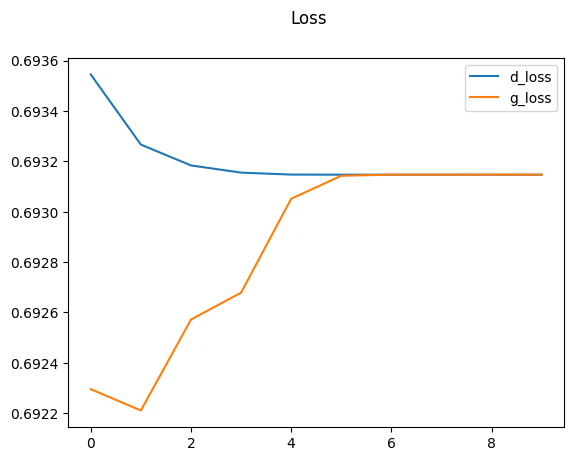

In [15]:
import matplotlib.pyplot as plt

plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()

# save the graph as a png file
plt.savefig(os.path.join(TRAINING_SESSION_PATH, "win_loss_ratios.png"))

plt.show()

In [16]:
import os

final_model_file_path = os.path.join(TRAINING_SESSION_PATH, 'models/final_model/weights')

# # Ensure the directory exists
if not os.path.exists(final_model_file_path):
    os.makedirs(final_model_file_path)

print(f"{TRAINING_SESSION_PATH}")
print(f"{os.path.join(final_model_file_path, 'generator_weights_final.keras')}")

# Save the models in the 'trained_models' directory using the .keras format
generator.save(os.path.join(final_model_file_path, 'generator_weights_final.keras'))
discriminator.save(os.path.join(final_model_file_path, 'discriminator_weights_final.keras'))

training_sessions/tf_12digit_pattern4_2023_11_11_232310
training_sessions/tf_12digit_pattern4_2023_11_11_232310/models/final_model/weights/generator_weights_final.keras


In [17]:
import shutil
import os
import zipfile

# Rename the folder
success_folder_path = f"{TRAINING_SESSION_PATH}_success"
os.rename(TRAINING_SESSION_PATH, success_folder_path)

# Ensure the target path exists, if not create it
target_path = "training_sessions/completed/"
if not os.path.exists(target_path):
    os.makedirs(target_path)

# Move the folder
shutil.move(success_folder_path, target_path)

 # Check if the directory exists
directory_path = os.path.join(target_path, success_folder_path) 
if not os.path.isdir(directory_path):
    print(f"No such directory: '{directory_path}'")

# If no zip filename is specified, use the directory name
zip_filename = os.path.basename(directory_path) + ".zip"

# Creating a zip file
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for foldername, subfolders, filenames in os.walk(directory_path):
        for filename in filenames:
            # create complete filepath of file in directory
            file_path = os.path.join(foldername, filename)
            # Add file to zip file
            zipf.write(file_path)

project_zip_path = os.path.join("training_sessions", "completed", f"{TRAINING_SESSION}_success")
success_folder_path = f"{TRAINING_SESSION}_success"

shutil.move(f"{TRAINING_SESSION}_success.zip", project_zip_path)

No such directory: 'training_sessions/completed/training_sessions/tf_12digit_pattern4_2023_11_11_232310_success'


'training_sessions/completed/tf_12digit_pattern4_2023_11_11_232310_success/tf_12digit_pattern4_2023_11_11_232310_success.zip'